In [27]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("..")  
from tqdm import tqdm
from utils.preprocessing import ( split_eye_image, resize_and_save_all)


# define source and target folders

# filtered are the output of nbk 1 - sharp imgs
filtered_healthy  = '../data/filtered/healthy_eye'
filtered_infected = '../data/filtered/infected_eye'

# sharp and individual imgs
split_healthy    = '../data/split/healthy_eye'
split_infected   = '../data/split/infected_eye'

# resized to 224x224 and model-ready
processed_healthy  = '../data/processed/healthy_eye'
processed_infected = '../data/processed/infected_eye'


for p in (split_healthy, split_infected, processed_healthy, processed_infected):
    os.makedirs(p, exist_ok=True)


In [28]:
skipped = []
for src, dst in [
    (filtered_healthy, split_healthy),
    (filtered_infected, split_infected)
]:
    label = os.path.basename(src)
    for fname in tqdm(os.listdir(src), desc=f"Splitting {label}"):
        img = cv2.imread(os.path.join(src, fname))
        if img is None:
            skipped.append((src, fname, "Unreadable"))
            continue
        split_eye_image(
            image        = img,
            fname_prefix = os.path.splitext(fname)[0],
            save_dir     = dst
        )

Splitting infected_eye: 100%|██████████| 507/507 [00:00<00:00, 832.09it/s]


In [29]:
# log splits
if skipped:
    pd.DataFrame(skipped, columns=['source','filename','reason']) \
      .to_csv('../logs/skipped_splits.csv', index=False)

In [30]:
# resize split imgs and save to proccessed
resize_and_save_all(split_healthy,  processed_healthy,  size=224)
resize_and_save_all(split_infected, processed_infected, size=224)
print("Processed images ready at:", processed_healthy, processed_infected)

Resizing to 224x224: 100%|██████████| 968/968 [00:01<00:00, 868.49it/s] 

Processed images ready at: ../data/processed/healthy_eye ../data/processed/infected_eye


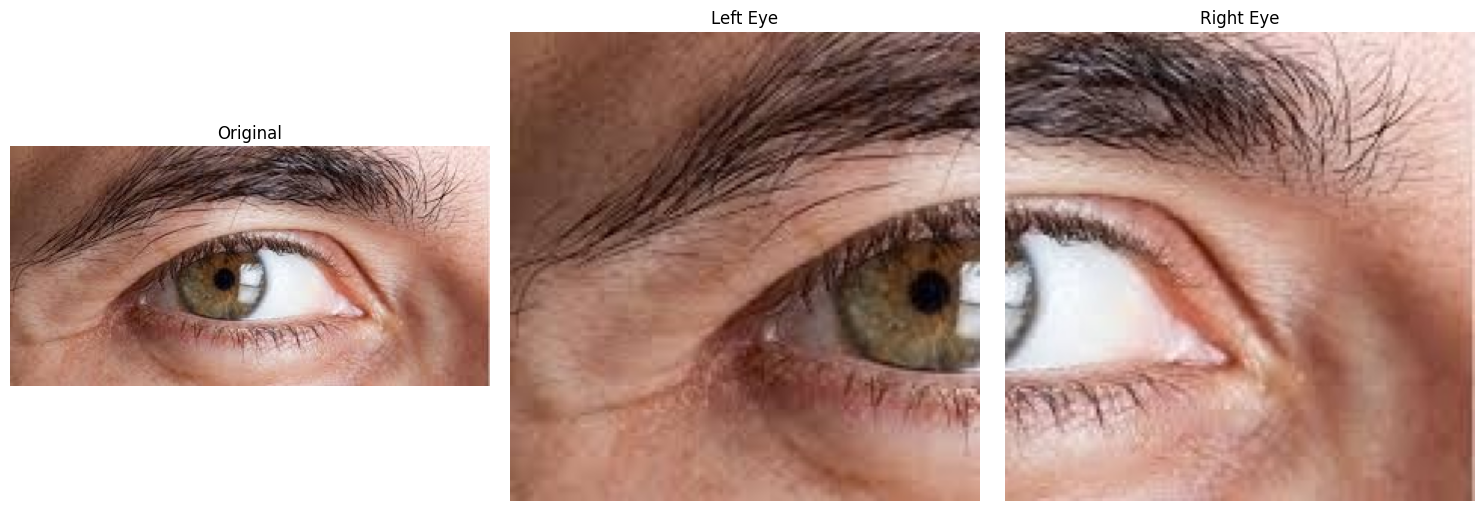

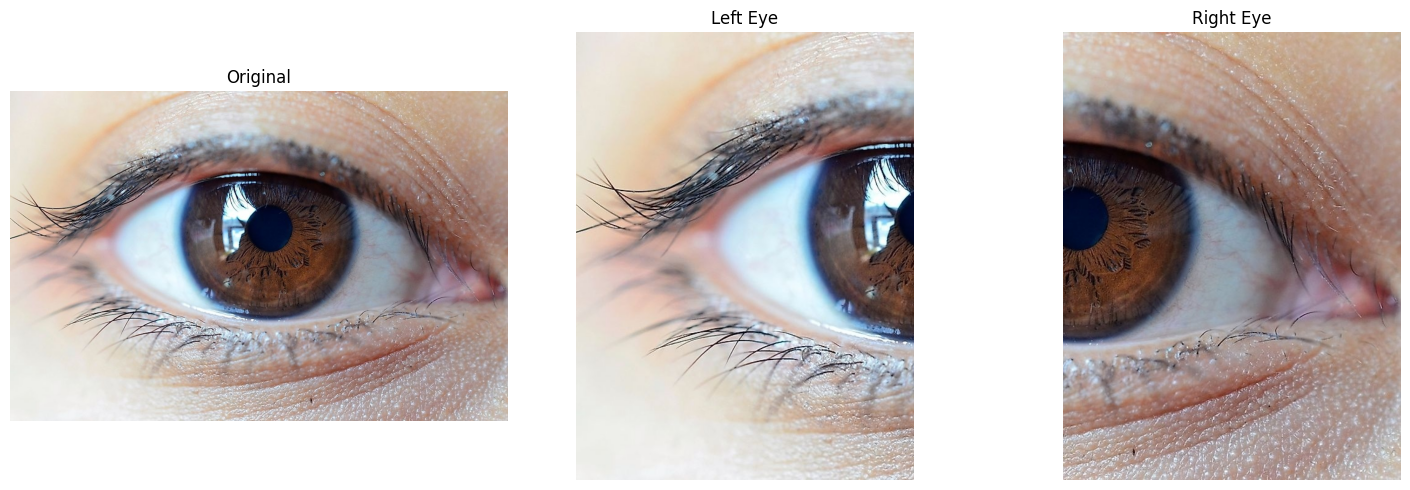

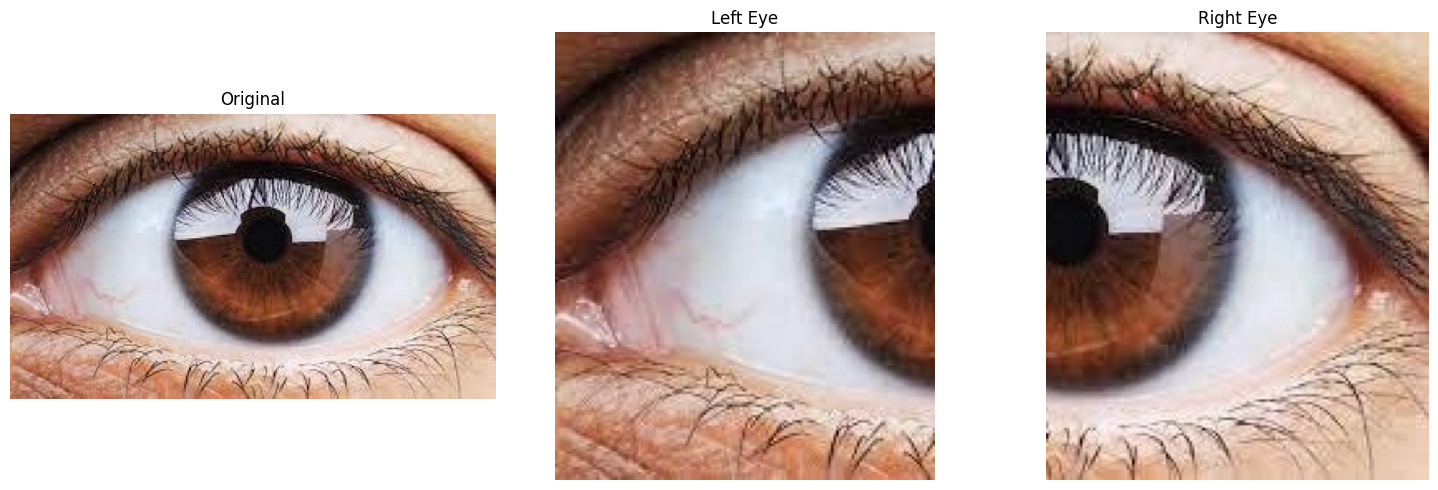

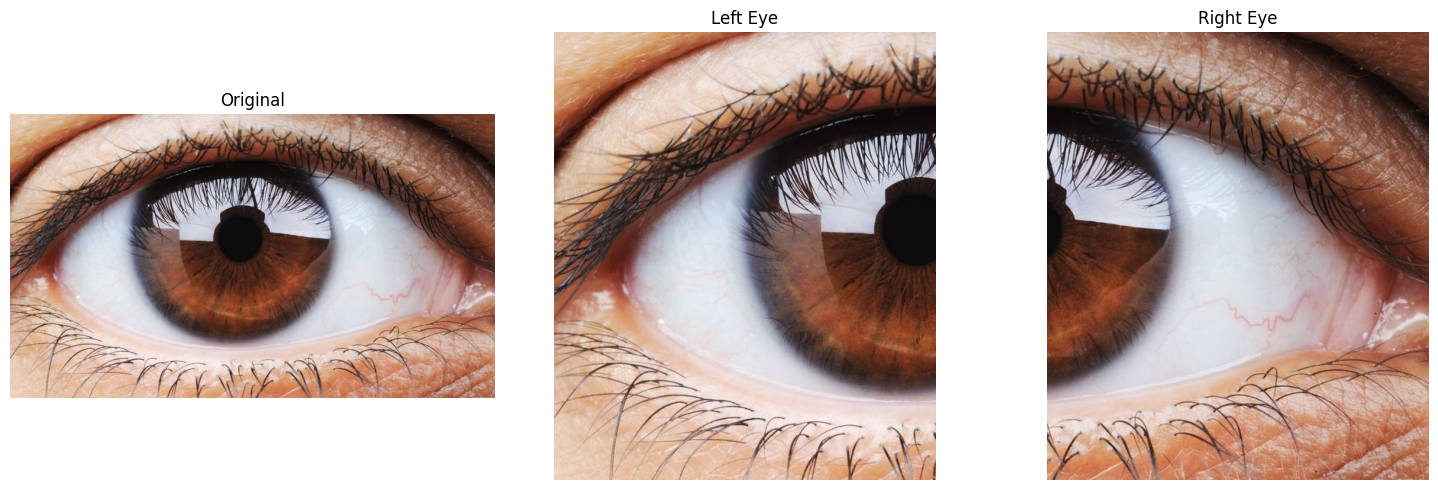

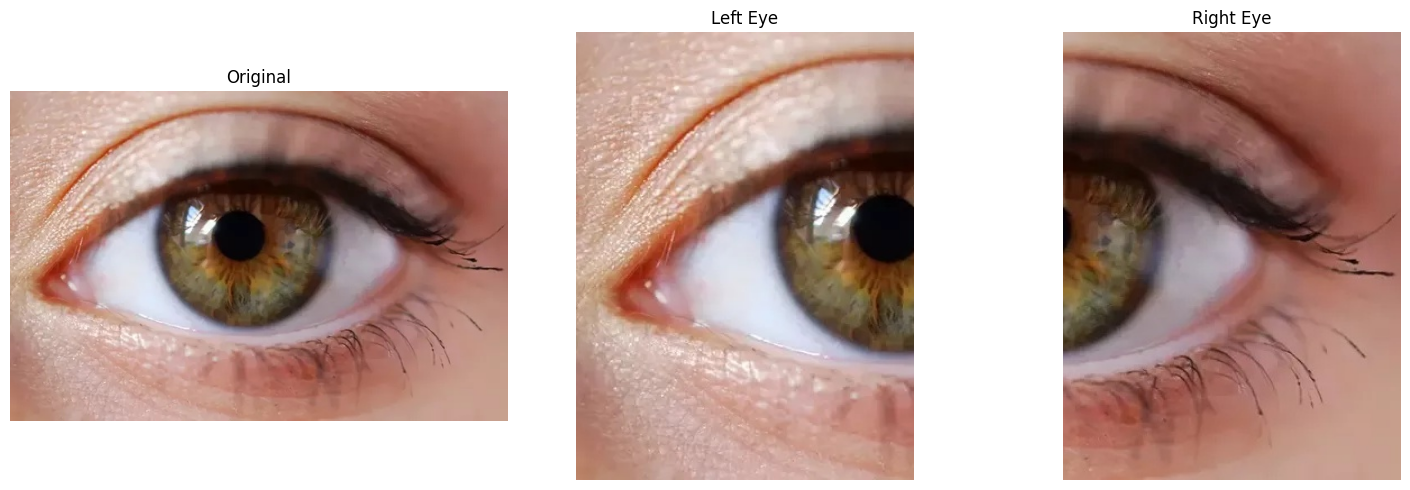

In [32]:
# %%
import os, cv2
import matplotlib.pyplot as plt

# point these at your folders
original_folder = filtered_healthy   # or filtered_infected
split_folder    = split_healthy      # or split_infected

# 1) build map of base → original filename
orig_map = {}
for fn in os.listdir(original_folder):
    base, ext = os.path.splitext(fn)
    orig_map[base] = fn

# 2) find all bases that have both left & right splits
bases = []
for fn in os.listdir(split_folder):
    if fn.endswith("_left.jpg"):
        base = fn[:-9]  # remove "_left.jpg"
        # make sure split exists AND original exists
        if os.path.exists(os.path.join(split_folder, f"{base}_right.jpg")) and base in orig_map:
            bases.append(base)

# 3) preview up to 5
for base in bases[:5]:
    orig_path  = os.path.join(original_folder, orig_map[base])
    left_path  = os.path.join(split_folder, f"{base}_left.jpg")
    right_path = os.path.join(split_folder, f"{base}_right.jpg")

    # read & validate
    orig_img = cv2.imread(orig_path)
    left_img = cv2.imread(left_path)
    right_img= cv2.imread(right_path)
    if orig_img is None or left_img is None or right_img is None:
        print(f"Skipping {base}: couldn't read all three files.")
        continue

    # convert and plot
    orig  = cv2.cvtColor(orig_img,  cv2.COLOR_BGR2RGB)
    left  = cv2.cvtColor(left_img,  cv2.COLOR_BGR2RGB)
    right = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(orig);  axs[0].set_title("Original"); axs[0].axis("off")
    axs[1].imshow(left);  axs[1].set_title("Left Eye"); axs[1].axis("off")
    axs[2].imshow(right); axs[2].set_title("Right Eye");axs[2].axis("off")
    plt.tight_layout()
    plt.show()